In [39]:
# %load instance_detector.py
from collections import Counter

import numpy as np

import cv2
from imageio import imread
import matplotlib.pyplot as plt

class InstanceDetector():

    def __init__(self, reference_image):
        self.reference_image = reference_image
        height, width = reference_image.shape[:2]
        # clockwise
        self.reference_vertices = np.vstack([
            (0, 0),
            (width, 0),
            (width, height),
            (0, height)
        ]).astype(np.float32).reshape(-1,1,2)

        # upper left and lower right corners
        self.corners_ul_lr = np.vstack([
            (width, 0),
            (0, height)
        ]).astype(np.float32)

        self.sift = cv2.xfeatures2d.SIFT_create()
        keypoints, descriptors = self.sift.detectAndCompute(self.reference_image, None)
        self.reference_keypoints = keypoints
        self.reference_descriptors = descriptors

    def detect_object(self, input_image, match_threshold=0.8,
    hough_num_bins=[2, 2, 2, 2], ransac_threshold=5.0):
        keypoints_input, keypoints_reference = self.extract_matching_keypoints(
            input_image, distance_threshold=match_threshold
        )

        points_input, points_reference = self.filter_keypoints_with_hough(
            keypoints_input, keypoints_reference, num_bins=hough_num_bins
        )

        transform_matrix = self.fit_homography(
            src=points_reference, dst=points_input, ransac_threshold=ransac_threshold
        )

        bounding_box_corners = cv2.perspectiveTransform(self.reference_vertices, transform_matrix)
        return bounding_box_corners

    def extract_matching_keypoints(self, input_image, distance_threshold):
        keypoints, descriptors = self.sift.detectAndCompute(input_image, None)
        # len(matches) == len(descriptors1)
        matches = cv2.BFMatcher().knnMatch(descriptors, self.reference_descriptors, k=2)

        # filter good matches above threshold
        good_keypoints = []
        good_keypoints_ref = []
        # two nearest neighbors for each match
        for m1, m2 in matches:
            if m1.distance > m2.distance * distance_threshold:
                continue
            kp = keypoints[m1.queryIdx]
            kp_ref = self.reference_keypoints[m1.trainIdx]
            good_keypoints.append(kp)
            good_keypoints_ref.append(kp_ref)

        return good_keypoints, good_keypoints_ref

    def transform_corners(self, keypoint_input, keypoint_reference):
        # kp.pt + (kp.size / kp_ref.size) * rotate(corners - kp_ref.pt, kp.angle - kp_ref.angle)
        offseted = self.corners_ul_lr - keypoint_reference.pt
        degrees = keypoint_input.angle - keypoint_reference.angle
        rotated = self.rotate(offseted, degrees)
        scale = keypoint_input.size / keypoint_reference.size
        transformed = keypoint_input.pt + scale * rotated
        return transformed

    def filter_keypoints_with_hough(self, keypoints_input, keypoints_reference, num_bins):
        # vote on four parameters, i.e., four points from two corner coordinates
        assert len(num_bins) == 4
        # construct raw votes, before quantization, num_keypoints x 4
        votes_raw = []
        for kp, kp_ref in zip(keypoints_input, keypoints_reference):
            # flatten to 4 params
            corners = self.transform_corners(kp, kp_ref).flatten()
            votes_raw.append(corners)
        votes_raw = np.vstack(votes_raw)

        # quantize votes into bins
        votes = []
        for i in range(votes_raw.shape[1]):
            param_votes_raw = votes_raw[:, i]
            # no need to save the histogram, only need the bins
            _, bins = np.histogram(param_votes_raw, bins=num_bins[i])
            param_votes = np.digitize(param_votes_raw, bins, right=False)
            votes.append(param_votes)
        votes = np.vstack(votes).T

        # count popular vote
        vote_tuples = tuple([tuple(row) for row in votes])
        vote_counter = Counter(vote_tuples)

        winner = vote_counter.most_common()[0][0]
        # keypoints that voted the winning vote
        keypoint_indices = np.where((votes == winner).all(axis=1))[0]

        # filter keypoints, only need point coordinates, not size or angle
        points_input = []
        points_reference = []
        for i in keypoint_indices:
            point = keypoints_input[i].pt
            point_ref = keypoints_reference[i].pt
            points_input.append(point)
            points_reference.append(point_ref)

        points_input = np.vstack(points_input).reshape(-1, 1, 2)
        points_reference = np.vstack(points_reference).reshape(-1, 1, 2)

        return points_input, points_reference

    def fit_homography(self, src, dst, ransac_threshold):
        _, mask = cv2.findHomography(src, dst, cv2.RANSAC, ransac_threshold)
        matches_mask = mask.ravel().tolist()
        inlier_indices = []
        for i, element in enumerate(matches_mask):
            if element == 1: # is an inlier
                inlier_indices.append(i)
        # refit model using inliers
        transform_matrix, _ = cv2.findHomography(
            src[inlier_indices], dst[inlier_indices], cv2.RANSAC, ransac_threshold
        )
        return transform_matrix

    @staticmethod
    def rotate(point, degrees):
        angle = np.deg2rad(degrees)
        R = np.array([[np.cos(angle), -np.sin(angle)],
                    [np.sin(angle),  np.cos(angle)]])
        return point @ R.T


In [40]:
dirname = 'stopsign/'
img_ref = imread(dirname + 'stop-reference.jpg')
img1 = imread(dirname + 'stop1.jpg')
img2 = imread(dirname + 'stop2.jpg')
img3 = imread(dirname + 'stop3.jpg')
img4 = imread(dirname + 'stop4.jpg')
img5 = imread(dirname + 'stop5.jpg')

In [41]:
detector = InstanceDetector(img_ref)

In [42]:
corners = detector.detect_object(img1)

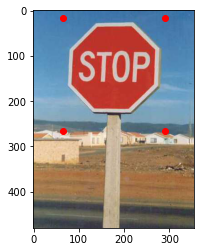

In [43]:
plt.imshow(img1)
plt.plot(corners[:, :, 0], corners[:, :, 1], 'ro')

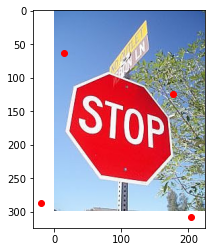

In [44]:
corners = detector.detect_object(img4)
plt.imshow(img4)
plt.plot(corners[:, :, 0], corners[:, :, 1], 'ro')